# Experiment 1 with Sine Function

Professor Larremore suggested starting with contact modeling, and gave us the following resources:

1. https://www.cdc.gov/fluview/overview/fluview-interactive.html

2. https://cmu-delphi.github.io/delphi-epidata/

In [2]:
# trying to use the epidata API

from delphi_epidata import Epidata
# we then use Epidata to grab the info we want

In [3]:
# Outpatient ILI Surveillance Network from the CDC splits groups by:
# 0-4
# 5-24
# 25-49
# 50-64
# 65+

Assuming there is no birth and death, the models will look like the following:

$\frac{dS}{dt} = -\frac{\beta S I}{N}$

$\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I$

$\frac{dR}{dt} = \gamma I$

where N = S + I + R is the total population.

Breaking it down into the 5 age groups gives us the following equations:

$$\frac{dS_0}{dt} = -\frac{\beta_0 S_0 (I_0 + I_1 + I_2 + I_3 + I_4)}{N}$$

$$\frac{dI_0}{dt} = \frac{\beta_0 S_0 (I_0 + I_1 + I_2 + I_3 + I_4)}{N} - \gamma_0 I_0$$

$$\frac{dR_0}{dt} = \gamma_0 I_0$$


$$\frac{dS_1}{dt} = -\frac{\beta_1 S_1 (I_0 + I_1 + I_2 + I_3 + I_4)}{N}$$

$$\frac{dI_1}{dt} = \frac{\beta_1 S_1 (I_0 + I_1 + I_2 + I_3 + I_4)}{N} - \gamma_1 I_1$$

$$\frac{dR_1}{dt} = \gamma_1 I_1$$


$$\frac{dS_2}{dt} = -\frac{\beta_2 S_2 (I_0 + I_1 + I_2 + I_3 + I_4)}{N}$$

$$\frac{dI_2}{dt} = \frac{\beta_2 S_2 (I_0 + I_1 + I_2 + I_3 + I_4)}{N} - \gamma_2 I_2$$

$$\frac{dR_2}{dt} = \gamma_2 I_2$$


$$\frac{dS_3}{dt} = -\frac{\beta_3 S_3 (I_0 + I_1 + I_2 + I_3 + I_4)}{N}$$

$$\frac{dI_3}{dt} = \frac{\beta_3 S_3 (I_0 + I_1 + I_2 + I_3 + I_4)}{N} - \gamma_3 I_3$$

$$\frac{dR_3}{dt} = \gamma_3 I_3$$


$$\frac{dS_4}{dt} = -\frac{\beta_4 S_4 (I_0 + I_1 + I_2 + I_3 + I_4)}{N}$$

$$\frac{dI_4}{dt} = \frac{\beta_4 S_4 (I_0 + I_1 + I_2 + I_3 + I_4)}{N} - \gamma_4 I_4$$

$$\frac{dR_4}{dt} = \gamma_4 I_4$$

where $N = (S_0 + S_1 + S_2 + S_3 + S_4) + (I_0 + I_1 + I_2 + I_3 + I_4) + (R_0 + R_1 + R_2 + R_3 + R_4)$

Since we are focused on modeling a single epidemic season, we chose to ignore aging between age groups, and for the same reason we are neglecting birth and death and focusing on constant population sizes.

In [4]:
# based on real data, this is what the past year of flu looks like in an SIR model:

# the flu season starts in october
pastYr = Epidata.fluview(['nat'], [Epidata.range(202440, 202539)]) # is this one too many?
print(pastYr['result'], pastYr['message'], len(pastYr['epidata']))

1 success 52


In [5]:
# now, we need to extract the number of individuals infected for each age group from each result
ageGroup0 = [] # each of these is a separate x data array
ageGroup1 = []
ageGroup2 = []
ageGroup3 = []
ageGroup4 = []
for week in pastYr['epidata']:
  temp = week['num_age_0']
  ageGroup0.append(temp)
  
  temp = week['num_age_1']
  ageGroup1.append(temp)
  
  temp = week['num_age_3']
  ageGroup2.append(temp)
  
  temp = week['num_age_4']
  ageGroup3.append(temp)
  
  temp = week['num_age_5']
  ageGroup4.append(temp)
  

print(ageGroup0)
print(len(ageGroup0))

[10165, 10726, 11015, 12585, 13397, 15050, 16289, 18034, 19868, 19972, 22152, 28860, 37435, 33451, 23592, 26014, 30197, 32918, 35164, 29512, 24727, 20599, 18328, 17084, 15049, 13724, 12006, 11722, 11255, 11081, 10325, 9851, 10013, 9743, 9683, 8244, 7520, 6489, 5997, 5123, 5092, 4516, 4657, 4557, 4848, 4958, 6042, 7034, 7347, 7173, 7638, 7511]
52


In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
# getting the starting values from the actual data
initialVals = Epidata.fluview(['nat'], 202439)['epidata'][0]
I0 = [initialVals['num_age_0'], initialVals['num_age_1'], initialVals['num_age_3'], initialVals['num_age_4'], initialVals['num_age_5']]
print(I0)

[9467, 16115, 12155, 4627, 4482]


In [8]:
gamma = 1 # since our timestep is a week
pop = 3.33e8 # size of US population from November 2024
# what are the approximate sizes of each age group
S0 = [0.06*pop, 0.26*pop, 0.33*pop, 0.18*pop, 0.17*pop]
R0 = np.zeros(5)
# these should be absolute counts
print(S0)
print(I0)
print(R0)

def betaFunc(t, params):
  return params[0] * np.sin(2*np.pi/52*t + params[1]) + params[2]

def SIR_age_modified(tvals, a0, b0, c0, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4): # SIR model with age groups -> ratios
  tmax = len(tvals) 
  
  G = 5 # hard coding the number of groups
  S = np.zeros([tmax,G])
  I = np.zeros([tmax,G])
  R = np.zeros([tmax,G])
  incidence = np.zeros([tmax, G])
  N = 0
  
  param0 = [a0, b0, c0]
  param1 = [a1, b1, c1]
  param2 = [a2, b2, c2]
  param3 = [a3, b3, c3]
  param4 = [a4, b4, c4]
    
  paramList = [param0, param1, param2, param3, param4]
  for idx in range(tmax): # note that index is also the t
      if idx==0:
          S[idx] = S0
          I[idx] = I0
          R[idx] = R0
          incidence[idx] = S0
          N = sum(S[0,:] + I[0,:] + R[0,:])
      else:
          for group in range(0, G):
              Isum = (I[idx - 1, 0] + I[idx - 1, 1] + I[idx - 1, 2] + I[idx - 1, 3] + I[idx - 1, 4]).sum()
              beta = betaFunc(idx, paramList[group])
              inc = S[idx - 1, group] * beta * Isum / N
              dS_dt = -inc
              dI_dt = inc - gamma*I[idx - 1, group]
              dR_dt = gamma*I[idx - 1, group]
              
              incidence[idx, group] = inc
              
              S[idx, group] = S[idx-1,group] + dS_dt * 1
              I[idx, group] = I[idx-1,group] + dI_dt * 1
              R[idx, group] = R[idx-1,group] + dR_dt * 1
  
  return np.concatenate([incidence[:, 0], incidence[:, 1], incidence[:, 2], incidence[:, 3], incidence[:, 4]])

# we need to make a good guess to not get stuck in a local minimum
p0 = [1, 1, 1.2, 1, 1, 1.2, 1, 1, 1.2, 1, 1, 1.2, 1, 1, 1.2]

[19980000.0, 86580000.0, 109890000.0, 59940000.0, 56610000.00000001]
[9467, 16115, 12155, 4627, 4482]
[0. 0. 0. 0. 0.]


In [9]:
ydata = np.concatenate([ageGroup0, ageGroup1, ageGroup2, ageGroup3, ageGroup4])
x = np.arange(1, len(ageGroup0) + 1)

# running scipy.optimize.curve_fit which uses non-linear least squares to fit a function to data

params, pcov = scipy.optimize.curve_fit(SIR_age_modified, x, ydata, p0 = p0)
print(params)

C:\Users\tbgod\AppData\Local\Temp\ipykernel_10420\3725512275.py:42: RuntimeWarning: overflow encountered in scalar multiply
  inc = S[idx - 1, group] * beta * Isum / N
C:\Users\tbgod\AppData\Local\Temp\ipykernel_10420\3725512275.py:44: RuntimeWarning: invalid value encountered in scalar subtract
  dI_dt = inc - gamma*I[idx - 1, group]
C:\Users\tbgod\AppData\Local\Temp\ipykernel_10420\3725512275.py:40: RuntimeWarning: invalid value encountered in scalar add
  Isum = (I[idx - 1, 0] + I[idx - 1, 1] + I[idx - 1, 2] + I[idx - 1, 3] + I[idx - 1, 4]).sum()


[ 1.03023168  8.0988376   3.55424659  0.14717056  0.68449726  1.16201129
  0.14714053 -0.0212562   0.73077926  0.06935992  2.36040208  0.7087544
  0.10053113  2.51455211  0.75209057]


In [10]:
# what does the covariance tell us
print(np.linalg.cond(pcov)) # this is large, which is worrisome
print(np.diag(pcov))

272598.81300436717
[ 239929.57644313  233016.97547973  213886.95259171   10115.66341858
  711245.45093725   11141.95548594    9563.36352844  241276.72366031
    6733.80356519   34477.667358   3088030.3724947    23005.06800166
   39824.23858335 1681222.01091674   25772.32395153]


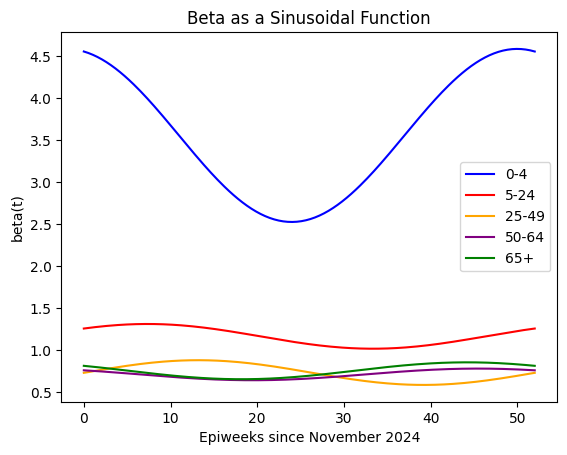

In [11]:
# graphing the betas against each other
beta0params = [params[0], params[1], params[2]]
beta1params = [params[3], params[4], params[5]]
beta2params = [params[6], params[7], params[8]]
beta3params = [params[9], params[10], params[11]]
beta4params = [params[12], params[13], params[14]]

x = np.linspace(0, 52, 200)
plt.plot(x, betaFunc(x, beta0params), color='blue', label="0-4")
plt.plot(x, betaFunc(x, beta1params), color='red', label="5-24")
plt.plot(x, betaFunc(x, beta2params), color='orange', label="25-49")
plt.plot(x, betaFunc(x, beta3params), color='purple', label="50-64")
plt.plot(x, betaFunc(x, beta4params), color='green', label="65+")
plt.xlabel("Epiweeks since November 2024")
plt.ylabel("beta(t)")
plt.title("Beta as a Sinusoidal Function")
plt.legend()
plt.show()

In [14]:
# what does an SIR simulation look like with these results?

def SIR_age(tvals, params): # SIR model with age groups -> ratios
  tmax = len(tvals) 
  
  G = 5 # hard coding the number of groups
  S = np.zeros([tmax,G])
  I = np.zeros([tmax,G])
  R = np.zeros([tmax,G])
  incidence = np.zeros([tmax, G])
  N = 0
  
  p0 = [params[0], params[1], params[2]]
  p1 = [params[3], params[4], params[5]]
  p2 = [params[6], params[7], params[8]]
  p3 = [params[9], params[10], params[11]]
  p4 = [params[12], params[13], params[14]]
  
  paramList = [p0, p1, p2, p3, p4]

  for idx in range(tmax): # note that index is also the t
      if idx==0:
          S[idx] = S0
          I[idx] = I0
          R[idx] = R0
          N = sum(S[0,:] + I[0,:] + R[0,:])
      else:
          for group in range(0, G):
              # calculating incidence because that is what the API returns
              Isum = I[idx - 1, 0] + I[idx - 1, 1] + I[idx - 1, 2] + I[idx - 1, 3] + I[idx - 1, 4]
              dS_dt = -S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N
              dI_dt = S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N - gamma*I[idx - 1, group]
              dR_dt = gamma*I[idx - 1, group]
              
              incidence[idx, group] = -dS_dt
              
              S[idx, group] = S[idx-1,group] + dS_dt * 1
              I[idx, group] = I[idx-1,group] + dI_dt * 1
              R[idx, group] = R[idx-1,group] + dR_dt * 1
  
  return S, I, R, incidence

# what does this look like for one year?
t = np.arange(0, 52, 1)
S, I, R, incidence = SIR_age(t, params)

fig, ax = plt.subplots()
ls = ['-',':']
colors = ['red', 'green', 'blue', 'purple', 'orange']
for group in [0, 1, 2, 3, 4]:
    #ax.plot(t,S[:,group], color='b', ls=ls[group], label='Susceptibles')
    #ax.plot(t,I[:,group], color=colors[group], ls=ls[0], label=f'I group {group}')
    ax.plot(t, incidence[:, group], color=colors[group], label="incidence")
    #ax.plot(t,R[:,group], color=colors[group], ls=ls[1], label=f'R group {group}')
# plotting actual infected data
I_obs = [ageGroup0, ageGroup1, ageGroup2, ageGroup3, ageGroup4]
for group in [0, 1, 2, 3, 4]:
    ax.plot(t, I_obs[group], color='black', label=f'Actual I Group {group}')
ax.set_xlabel('time')
ax.set_ylabel('people')
ax.set_title("Incidence calculated vs. observed")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ValueError: not enough values to unpack (expected 4, got 3)

[ 2.3938327   8.99785605  3.73566069  2.47538106  0.42980892  4.31465703
  6.12783129  1.12556651 -0.15515577  6.34151134  1.06310131  0.83895516
  0.37813921 15.25034548  1.35455325  0.56304814  0.3032588  13.45242125
  2.29239584  0.57810744]
4539792.265389484
[1.10524170e-01 4.59164781e-01 4.53827697e-01 2.38562843e-02
 6.10867686e-03 6.87212815e+00 5.07469523e+00 1.72068739e-03
 3.12111635e-02 1.94810259e+00 2.07682031e+00 3.51119179e-04
 1.17858722e-02 1.90504334e-01 2.58829012e-01 2.02116567e-03
 1.02246510e-02 7.96233556e-01 1.00016580e+00 2.85872490e-03]


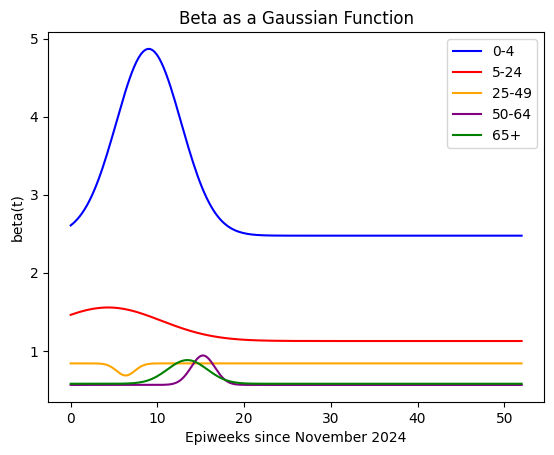

(0.0, 53.55)

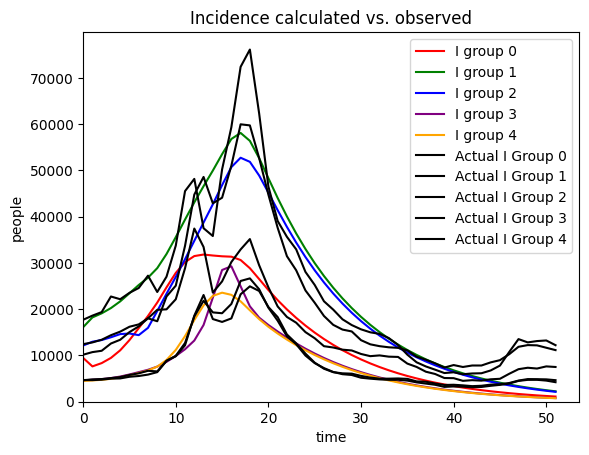

In [13]:
def betaFunc(t, params): # a gaussian pulse
  a, b, c, d = params
  return a * np.exp(-((t-b)**2)/(2*(c**2))) + d

def SIR_age_modified(tvals, a0, b0, c0, d0, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4): # SIR model with age groups -> ratios
  tmax = len(tvals) 
  
  G = 5 # hard coding the number of groups
  S = np.zeros([tmax,G])
  I = np.zeros([tmax,G])
  R = np.zeros([tmax,G])
  N = 0
  
  param0 = [a0, b0, c0, d0]
  param1 = [a1, b1, c1, d1]
  param2 = [a2, b2, c2, d2]
  param3 = [a3, b3, c3, d3]
  param4 = [a4, b4, c4, d4]
    
  paramList = [param0, param1, param2, param3, param4]
  for idx in range(tmax): # note that index is also the t
      if idx==0:
          S[idx] = S0
          I[idx] = I0
          R[idx] = R0
          N = sum(S[0,:] + I[0,:] + R[0,:])
      else:
          for group in range(0, G):
              beta = betaFunc(idx, paramList[group])
              Isum = I[idx - 1].sum()
              dS_dt = -S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N
              dI_dt = S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N - gamma*I[idx - 1, group]
              dR_dt = gamma*I[idx - 1, group]
              
              S[idx, group] = S[idx-1,group] + dS_dt * 1
              I[idx, group] = I[idx-1,group] + dI_dt * 1
              R[idx, group] = R[idx-1,group] + dR_dt * 1
  
  return np.concatenate([I[:, 0], I[:, 1], I[:, 2], I[:, 3], I[:, 4]])

ydata = np.concatenate([ageGroup0, ageGroup1, ageGroup2, ageGroup3, ageGroup4])
x = np.arange(1, len(ageGroup0) + 1)

# running scipy.optimize.curve_fit which uses non-linear least squares to fit a function to data

p0 = [3, 5, 2.4, 0.3, 3, 5, 2.4, 0.3, 3, 5, 2.4, 0.3, 3, 5, 2.4, 0.3, 3, 5, 2.4, 0.3]

params, pcov = scipy.optimize.curve_fit(SIR_age_modified, x, ydata, p0 = p0)
print(params)

# what does the covariance tell us
print(np.linalg.cond(pcov)) # this is large, which is worrisome
print(np.diag(pcov))

# graphing the betas against each other
beta0params = [params[0], params[1], params[2], params[3]]
beta1params = [params[4], params[5], params[6], params[7]]
beta2params = [params[8], params[9], params[10], params[11]]
beta3params = [params[12], params[13], params[14], params[15]]
beta4params = [params[16], params[17], params[18], params[19]]

x = np.linspace(0, 52, 200)
plt.plot(x, betaFunc(x, beta0params), color='blue', label="0-4")
plt.plot(x, betaFunc(x, beta1params), color='red', label="5-24")
plt.plot(x, betaFunc(x, beta2params), color='orange', label="25-49")
plt.plot(x, betaFunc(x, beta3params), color='purple', label="50-64")
plt.plot(x, betaFunc(x, beta4params), color='green', label="65+")
plt.xlabel("Epiweeks since November 2024")
plt.ylabel("beta(t)")
plt.title("Beta as a Gaussian Function")
plt.legend()
plt.show()

# what does an SIR simulation look like with these results?

def SIR_age(tvals, params): # SIR model with age groups -> ratios
  tmax = len(tvals) 
  
  G = 5 # hard coding the number of groups
  S = np.zeros([tmax,G])
  I = np.zeros([tmax,G])
  R = np.zeros([tmax,G])
  N = 0
  
  p0 = [params[0], params[1], params[2], params[3]]
  p1 = [params[4], params[5], params[6], params[7]]
  p2 = [params[8], params[9], params[10], params[11]]
  p3 = [params[12], params[13], params[14], params[15]]
  p4 = [params[16], params[17], params[18], params[19]]
  
  paramList = [p0, p1, p2, p3, p4]

  for idx in range(tmax): # note that index is also the t
      if idx==0:
          S[idx] = S0
          I[idx] = I0
          R[idx] = R0
          N = sum(S[0,:] + I[0,:] + R[0,:])
      else:
          for group in range(0, G):
              # calculating incidence because that is what the API returns
              Isum = I[idx - 1, 0] + I[idx - 1, 1] + I[idx - 1, 2] + I[idx - 1, 3] + I[idx - 1, 4]
              dS_dt = -S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N
              dI_dt = S[idx - 1, group] * betaFunc(idx, paramList[group]) * Isum / N - gamma*I[idx - 1, group]
              dR_dt = gamma*I[idx - 1, group]
              
              S[idx, group] = S[idx-1,group] + dS_dt * 1
              I[idx, group] = I[idx-1,group] + dI_dt * 1
              R[idx, group] = R[idx-1,group] + dR_dt * 1
  
  return S, I, R

# what does this look like for one year?
t = np.arange(0, 52, 1)
S, I, R = SIR_age(t, params)

fig, ax = plt.subplots()
ls = ['-',':']
colors = ['red', 'green', 'blue', 'purple', 'orange']
for group in [0, 1, 2, 3, 4]:
    #ax.plot(t,S[:,group], color='b', ls=ls[group], label='Susceptibles')
    ax.plot(t,I[:,group], color=colors[group], ls=ls[0], label=f'I group {group}')
    #ax.plot(t,R[:,group], color=colors[group], ls=ls[1], label=f'R group {group}')
# plotting actual infected data
I_obs = [ageGroup0, ageGroup1, ageGroup2, ageGroup3, ageGroup4]
for group in [0, 1, 2, 3, 4]:
    ax.plot(t, I_obs[group], color='black', label=f'Actual I Group {group}')
ax.set_xlabel('time')
ax.set_ylabel('people')
ax.set_title('Incidence calculated vs. observed')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)